In [58]:
using  Gen
using Plots

include("../step01-importing-data/utilities/read-files.jl")
DF = ReadDF("../../data/processed/DetrendedCov.csv")
xs = DF.Date
ys = DF.N1
include("../step02-linear-model/utilities/visualize.jl")

VizGenMCMC

We are defining a model with subchunks of 20 data points. The slope of our model follow a quadratic model. We follow the first derivative of the previous chunks.

In [59]:
SubChunkSize = 50
function DiffrenceIndex(i)
    return(div(i,SubChunkSize,RoundUp))
end
function SubXDif(xs,i)
    return(xs[i] - xs[div(i-1,SubChunkSize,RoundDown)*SubChunkSize+1])
end

function yValCalc(xs::Vector{Float64}, Buffer_y::Float64, Slopes::Vector{Float64}, Buffer_SubSlope::Float64)
    n = length(xs)
    NumChunks = DiffrenceIndex(n)


    #The SubSlope is defined by the previous slopes and the initial subslope
    SubSlope = cumsum(pushfirst!([SubChunkSize * Slopes[i] for i=1:NumChunks], Buffer_SubSlope))
    
     #calculates the change of y from the previous chunk to the current x. We combine this with a set of y offset values
    #in the next step to get the true mu fed into the normal distribution
    #TrueDeltaMu n = Slope[chunk](x[i]- x[Last chunk])
    TrueDeltaMu = [Slopes[DiffrenceIndex(i)]*SubXDif(xs,i)^2 + SubSlope[DiffrenceIndex(i)]*SubXDif(xs,i) for i=1:n]

    #calculating the 'y intercept' of each chunk to make sure each line connects to the last one
    #Because each intercept gets added to the last one we take the cumalitive sum to get the total offset needed at each step
    #The first value should be the initial offset Buffer_y to get everything aligned
    #ysOfseted = [Buffer_y, Slope[chunk](x[chunk]- x[Last chunk])]
    ysOfseted = cumsum(pushfirst!([TrueDeltaMu[(i)*SubChunkSize] - TrueDeltaMu[(i-1)*SubChunkSize+1] for i=1:(NumChunks-1)],Buffer_y))


    ys = [TrueDeltaMu[i] + ysOfseted[DiffrenceIndex(i)] for i=1:n]
end

yValCalc (generic function with 1 method)

We are defining parameters like slope, noise, and outliers, and also we are using the quadratic model that we defined previously.

In [60]:
@gen function Quad_spline_with_outliers_smooth(xs::Vector{<:Real})
    # First, we get some numbers and functions needed for the rest of the analysis
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)

    # Next, we generate some parameters of the model. There are three types of randomly made perameters. First are the constant ones
    #That are unique to the process. These are generated first.
    #Second are the ones that are unique to the individual chunks. These loop from 1 to NumChunks
    #Last are the ones that vary for every point. These range from 1 to n


    #Unique to process
#
    #Where the series starts. In the log model this is around 12 and I give it a pretty big window
    Buffer_y ~ normal(1000, 10000) 
    Buffer_SubSlope ~ normal(0, 200)

    #the probability any given point is a outlier
    prob_outlier ~ uniform(.05, .1)
    
    #The scaling factor on outliers:
    OutlierDeg ~ uniform(1, 5)
    
    #unique to chunk

    #The data apears to have no slope over 3 so a sd of 2 should capture the true slopes with high probability
    Slopes = [{(:slope, i)} ~ normal(0, 200) for i=1:NumChunks]



    #The distribution of the noise. It gets fed into the sd of a normal distribution so the distribution of the noise needs to be always positive
    noise = [{(:noise, i)} ~ gamma(200, 200) for i=1:NumChunks]



    #EveryPoint

    #is using the prob_outlier vector above to decide if each point is an outlier. the model we are using now has 
    #The slope and sd $OutlierDeg times larger then the non outliers. so we times the mu and sd by this value in the last step
    PointOutlier = ((OutlierDeg-1)*[{:data => i => :is_outlier} ~ bernoulli(prob_outlier) for i=1:n] .+ 1)

   

    #The random var fit to the actual data. It is created as a combination of previous parts
    #The process was discribed in previous steps
    #ys = normal(mu, sd)

    TrueVec = yValCalc(xs,Buffer_y,Slopes,Buffer_SubSlope)
    ys = [{:data => i => :y} ~ 
        normal(
            TrueVec[i]*PointOutlier[i],                              #mean of normal rand var
            noise[DiffrenceIndex(i)] #var of normal rand var
        ) 
        for i=1:n]
    ys
end;

We are assigning the variables with the data and parameters that we have to prepare for ploting.

In [61]:
#Get seralize trace to accept function instaed of unique code for each version
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    slopes = [trace[(:slope, i)] for i in 1:NumChunks]
    FlatDict = Dict(
          :points => zip(xs, [trace[:data => i => :y] for i in 1:n]),
          :outliers => [trace[:data => i => :is_outlier] for i in 1:n],
         :xs => xs,
         :ys => yValCalc(xs, trace[:Buffer_y], slopes,trace[:Buffer_SubSlope]))
    return(FlatDict)
end

serialize_trace (generic function with 1 method)

Create random line using generative function

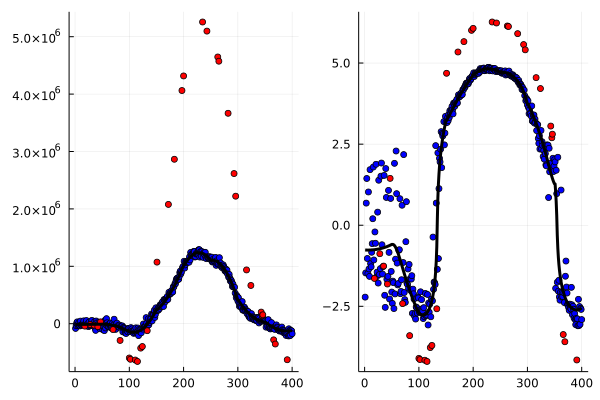

In [62]:
VizGenModel(Quad_spline_with_outliers_smooth)

Assign our setup for ploting into variable named observations.

In [63]:
observations = make_constraints(ys);

We are creating a block simulation of our data points and model.

In [64]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    (xs,) = get_args(tr)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)

    for j = 1:(NumChunks)
        # Block 1: Update the line's parameters
        line_params = select((:noise,j-2), (:slope,j-2),
                    (:noise,j-1), (:slope,j-1),
                    (:noise,j), (:slope,j),
                    (:noise,j+1), (:slope,j+1),
                    (:noise,j+1), (:slope,j+2),
                    :Buffer_y, :Buffer_SubSlope)
        (tr, _) = mh(tr, line_params)
    end
    
    # Blocks 2-N+1: Update the outlier classifications
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end

    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier,:OutlierDeg, :Buffer_y, :Buffer_SubSlope))
    # Return the updated trace
    tr
end;

Visualizing our data points and quadratic model into a graph. We are iterating 200 times.

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_Xxxc3UajVk.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\rDbWY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_Xxxc3UajVk.gif")
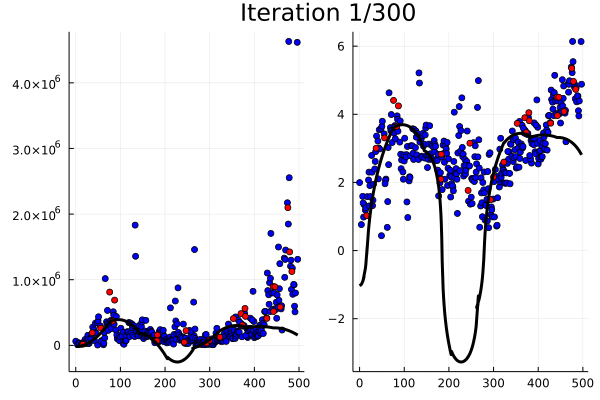

In [65]:
VizGenMCMC(Quad_spline_with_outliers_smooth, xs, observations,block_resimulation_update, 300)